In [82]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pyDOE import lhs as latin_hyper_cube

from models import RandomEffects
from adaptive_path_estimator import PathEstimator
from smc.utils import ProgressBar

import seaborn as sns
%matplotlib inline

## Fixed Effects to Random Effects.

In this document I compare a simple fixed effects model to the equivalent random effects model. The likelihood for either model is:

$$ Y_{i,j} \sim \mathcal{N}(\mu_j, \sigma^2)$$

Index $j$ is the group label and $i$ denotes the $i$-th individual in that group. The observation noise is assigned the improper prior

$$ p(\sigma^2) \propto \frac{1}{\sigma^2}$$


#### Fixed effects prior

$$ p(\mu_j) \propto 1 $$

Standard flat prior, leads to poor estimation when the number of observations is low.

#### Random effects prior

$$ \mu_j \sim \mathcal{N}(\mu, \tau^2)$$

$$ \mu \sim \mathcal{N}(0, \lambda \cdot \tau^2)$$

$$ \tau^2 \sim \mathcal{IG}(a,b)$$

I've chosen $a=2, b=2$ and $\lambda=1$ which implies a $t$ distribution on $\mu$ with $4$ degress of freedom. I can look up some better rules for specifying these priors when I get my copy of BDA3 back. 

The ratio $\rho = \frac{\tau^2}{\tau^2 + \sigma^2}$ is called the interclass correlation and measures the relative strength of the sources of variation. When this is close to $1$ the between group variance dominates

In [2]:
# Model parameters
J, N = 10, 5
a = 2.0
b = 2.0
total_variance = 10**2
rho = 0.2

# Init the model and draw data
RE = RandomEffects(a, b, load=True)
summaries, true_params = RE.generate_data(J, N, 10.0**2, 0.2)

Loading Stan model...


## Geometric mixture

In order to do path sampling, both models need to be embbeded in the same space. We accomplish this by placing the same prior on $(\mu, \tau^2)$ for the fixed effects model, which doesn't change the normalizing constant as this distribution is properly normalized. For the geometric mixture, the potential is simply the $\log$-importance sampling weight, which is the log-pdf of the random effect prior.

$$ U_1\big(\mu_1,\ldots,\mu_J,\sigma^2,\mu,\tau^2\big) = -0.5\sum_{j=1}^J \Big[ \log \tau^2  + \frac{(\mu_j - \mu)^2}{\tau^2}\Big]$$

This term becomes large when either the $\mu_j$ terms are quite far from $\mu$ or $\tau^2$ is very small. Both things happen during the first step of tempering.

In [10]:
# Estimate t
mixtures = 2.0**-np.arange(0,25)[::-1]
u_var = []
pb = ProgressBar(len(mixtures))

params = (0.0, 1.0)
fit, u = RE.mcmc(summaries, params, 10**4)
u_var.append(u.var(0)[0])

for m in mixtures:
    params = (m, 1.0)
    fit, u = RE.mcmc(summaries, params, 10**4)
    u_var.append(u.var(0)[0])
    pb.increment()
pb.finish()
u_var = np.array(u_var)

% complete:  4 16 28 40 52 64 76 88 100 
Elapsed time: 14.6 seconds.


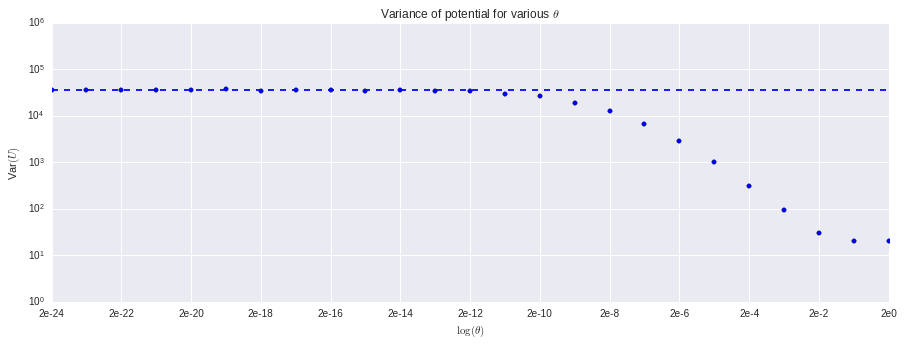

In [9]:
plt.rcParams['figure.figsize'] = 15, 5

plt.scatter(np.log(mixtures), u_var[1:])
plt.semilogy()
plt.xlabel(r'$\log(\theta)$')
plt.ylabel(r'Var$(U)$')
plt.axhline(u_var[0], ls='--')
plt.title(r'Variance of potential for various $\theta$')
plt.ylim(1,10**6)
plt.xticks(np.log(mixtures)[::2], ['2e{}'.format(i) for i in -np.arange(0,25)[::-1]][::2] )
plt.xlim(np.log(mixtures).min(), 0)
plt.show()

## Prior path
The idea behind this path is that the problem can be fixed by changing the prior on $\tau^2$. When the random effects variance is large enough (on average) the potential becomes small and therefor the variance decreases. The prior path has the following pdf:

$$p(\ldots \mid \theta, s) \propto \mathcal{L}(Y \mid \ldots) \cdot \prod_{j=1}^J \mathcal{N}^{\theta}(\mu_j \mid \mu, \tau^2) \cdot \mathcal{N}(\mu \mid 0, \tau^2) \cdot \mathcal{IG}(\tau^2 \mid a,\,b\cdot s^{-1})\cdot \frac{1}{\sigma^2}$$

The scaling term $s$ changes the variance of the prior on $\tau^2$ allowing for reduction in the size of the mixture-potential. This term is like an inverse tempering term, in that it should be moved towards $0$ and then returned to $1.0$

In [35]:
# Estimate 
scales = 2.0**-np.linspace(0,8,25)
u_var = []
pb = ProgressBar(len(scales))

for s in scales:
    params = (0.0, s)
    fit, u = RE.mcmc(summaries, params, 10**4)
    u_var.append(u.var(0))
    pb.increment()
pb.finish()
u_var = np.array(u_var)

% complete:  4 16 28 40 52 64 76 88 100 
Elapsed time: 12.6 seconds.


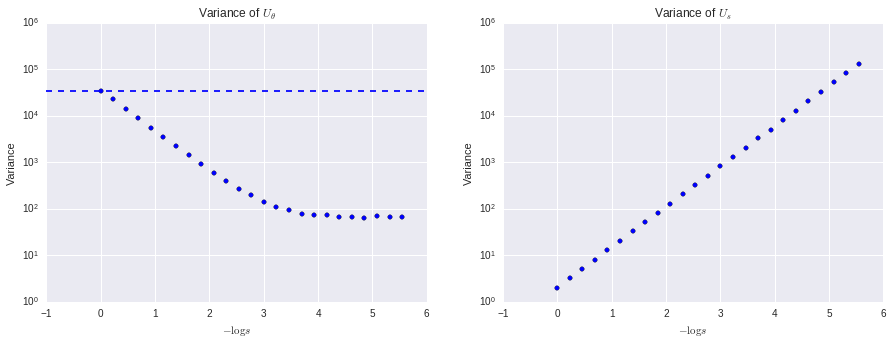

In [36]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(121)
plt.scatter(-np.log(scales), u_var[:, 0])
plt.semilogy()
plt.xlabel('log (mixture)')
plt.axhline(u_var[0,0], ls='--')
plt.title(r'Variance of $U_\theta$')
plt.xlabel(r'$-\log s$')
plt.ylabel('Variance')
plt.ylim(1,10**6)

plt.subplot(122)
plt.scatter(-np.log(scales), u_var[:, 1])
plt.semilogy()
plt.xlabel(r'$-\log s$')
plt.title(r'Variance of $U_s$')
plt.ylabel('Variance')
plt.ylim(1,10**6)

plt.show()

## Manifold estimation


In [118]:
# Initialize the manifold estimator
cutoff = 10**-4
est = PathEstimator(None, 2, [0.0, cutoff], [1.0,1.0], ['linear','log_decreasing'])

# choose a series of design points
n_grid = 500
design = latin_hyper_cube(2, n_grid)

# sample at each point
pb = ProgressBar(len(design))
samples = []

for params in design:
    fit, u = RE.mcmc(summaries, params, 10**4)
    samples.append(u)
    pb.increment()
samples = np.array(samples)
pb.finish()

# Fit the manifold 
est._fit_energy(samples, design, log_transforms=[False, False], raw_samples=False, verbose=False)

# estimate the energy
ts = np.linspace(0,1,100)
betas = np.linspace(cutoff*2,1,101)[1:]
params = np.array(np.meshgrid(ts, betas)).reshape(2,-1).T
predictions = est.predict_energy(params)

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 310.9 seconds.


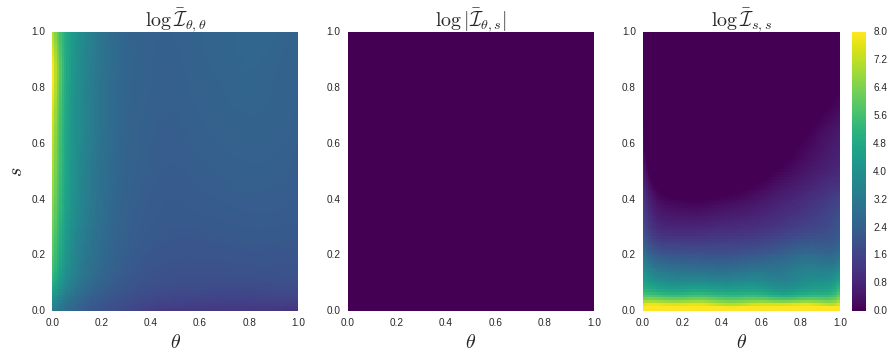

In [119]:
plt.rcParams['figure.figsize'] = 15, 5
cmap = plt.cm.viridis

# Compute the estimated values
est_energy_t = predictions[:,0,0].reshape(100,100)
est_energy_beta = predictions[:,1,1].reshape(100,100)
est_energy_cov = predictions[:,1,0].reshape(100,100)

# Plot the estimated values
plt.subplot(131)
plt.pcolor(np.log(est_energy_t), vmin=0, cmap=cmap)
plt.title(r'$\log\,\bar{\mathcal{I}}_{\theta,\theta}$', fontsize=20)
plt.yticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.ylabel(r'$s$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.xlabel(r'$\theta$', fontsize=20)

plt.subplot(132)
plt.pcolor(np.log(np.abs(est_energy_cov)), vmin=0, vmax=8, cmap=cmap)
plt.title(r'$\log\, |\bar{\mathcal{I}}_{\theta, s}|$', fontsize=20)
plt.yticks(np.linspace(0,100,6), np.linspace(0,1,6))
#plt.ylabel(r'$s$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.xlabel(r'$\theta$', fontsize=20)

plt.subplot(133)
plt.pcolor(np.log(est_energy_beta), vmin=0, vmax=8.0, cmap=cmap)
plt.colorbar()
plt.title(r'$\log\,\bar{\mathcal{I}}_{s, s}$', fontsize=20)
plt.yticks(np.linspace(0,100,6), np.linspace(0,1,6))
#plt.ylabel(r'$s$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.xlabel(r'$\theta$', fontsize=20)

plt.show()

# Explore the distribution of the fixed effects model

#### When interclass correlation is small and sample sizes are small...

- estimates of random effects are driven by integroup variability and poorly estimated
- observation variances is under estimated

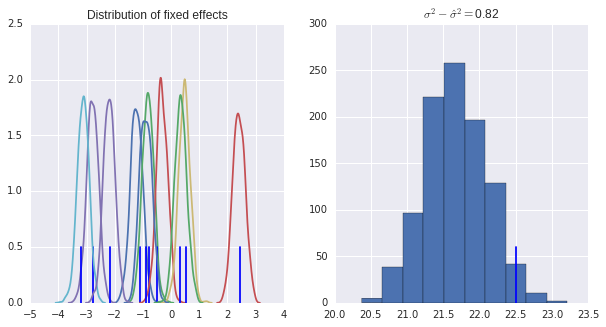

In [6]:
N, J, S = 5*10**2, 10, 10**3
RE = RandomEffects()

summaries, true_params = RE.generate_data(J, N, 25.0, 0.1)
fixed_posterior = RE.sample_fixed_effects(S, summaries)

plt.rcParams['figure.figsize'] = 10, 5
plt.subplot(121)
for true, params in zip(true_params[0], fixed_posterior[0].T):

    sns.distplot(params, hist=False)
    plt.axvline(true,0, 0.2)
plt.title('Distribution of fixed effects')
    
plt.subplot(122)
plt.hist(fixed_posterior[2])
plt.axvline(true_params[2], 0, 0.2)
plt.title(r'$\sigma^2 - \hat\sigma^2=${0:.2f}'.format(true_params[2]-fixed_posterior[2].mean()))  
plt.show()

#### For larger interclass correlations this disappears...

- estimates of fixed effects are well estimated
- observation variances is better estimated

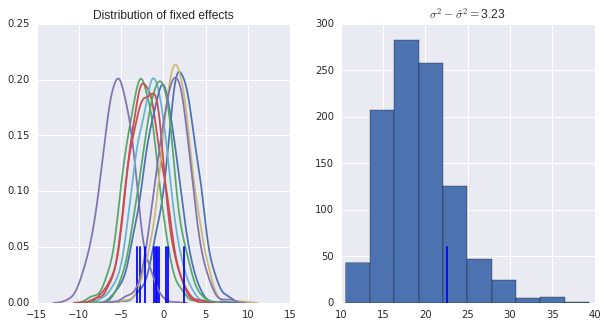

In [4]:
N, J, S = 5*10**0, 10, 10**3
RE = RandomEffects()

summaries, true_params = RE.generate_data(J, N, 25.0, 0.1)
fixed_posterior = RE.sample_fixed_effects(S, summaries)

plt.rcParams['figure.figsize'] = 10, 5
plt.subplot(121)
for true, params in zip(true_params[0], fixed_posterior[0].T):

    sns.distplot(params, hist=False)
    plt.axvline(true,0, 0.2)
plt.title('Distribution of fixed effects')
    
plt.subplot(122)
plt.hist(fixed_posterior[2])
plt.axvline(true_params[2], 0, 0.2)
plt.title(r'$\sigma^2 - \hat\sigma^2=${0:.2f}'.format(true_params[2]-fixed_posterior[2].mean()))  
plt.show()

#### Larger sample sizes also improve this problem...

- estimates of fixed effects are well estimated
- observation variances is better estimated

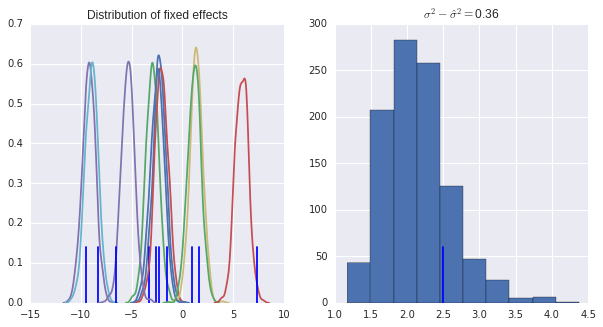

In [5]:
N, J, S = 5*10**0, 10, 10**3
RE = RandomEffects()

summaries, true_params = RE.generate_data(J, N, 25.0, 0.9)
fixed_posterior = RE.sample_fixed_effects(S, summaries)

plt.rcParams['figure.figsize'] = 10, 5
plt.subplot(121)
for true, params in zip(true_params[0], fixed_posterior[0].T):

    sns.distplot(params, hist=False)
    plt.axvline(true,0, 0.2)
plt.title('Distribution of fixed effects')
    
plt.subplot(122)
plt.hist(fixed_posterior[2])
plt.axvline(true_params[2], 0, 0.2)
plt.title(r'$\sigma^2 - \hat\sigma^2=${0:.2f}'.format(true_params[2]-fixed_posterior[2].mean()))  
plt.show()